In [1]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# model
from darts import TimeSeries
from darts.models import NaiveSeasonal
from darts.metrics import rmse, r2_score
from darts.models import NaiveDrift
from darts.models import NaiveEnsembleModel

In [2]:
# Load the electric dataset(CSV) into a Pandas DataFrame
df_el = pd.read_csv('Day-ahead Prices.csv')
# Select the desired columns
df_el = df_el[['MTU (CET/CEST)', 'Day-ahead Price [EUR/MWh]']]

# Rename the columns
df_el = df_el.rename(columns={'MTU (CET/CEST)': 'date', 'Day-ahead Price [EUR/MWh]': 'price'})

# Extract the first 16 characters from the 'date' column
df_el['date'] = df_el['date'].apply(lambda x: x[0:16])

# Drop rows where 'price' column is equal to '-'
df_el.drop(df_el[df_el['price'] == '-'].index, inplace=True)

median_price = df_el['price'].median()
df_el['price'].fillna(median_price, inplace=True)

# keep the data type(str, float64), if we did not the below work we meet an error.
df_el['date'] = pd.to_datetime(df_el['date'], format='%d.%m.%Y %H:%M')
df_el['price'] = df_el['price'].astype(float)
ts = TimeSeries.from_dataframe(df_el, time_col='date', value_cols = 'price', fill_missing_dates=False, freq='H')

#split_date = pd.Timestamp(year=2023, month=5, day=1, hour=0)  # Change the month and day here
#train, test = ts.split_after(split_date)

df_el['date'] = pd.to_datetime(df_el['date'], format='%m.%d.%Y %H:%M')
ts = TimeSeries.from_dataframe(df_el, time_col='date', value_cols = 'price', fill_missing_dates=False, freq='H')
train, test = ts.split_after(pd.Timestamp("05.01.2023 00:00"))

### 01_Ensemble model, combined_forecast with NaiveSeasonal model & Drift 

Model NaiveSeasonal() obtains RMSE: 46.76


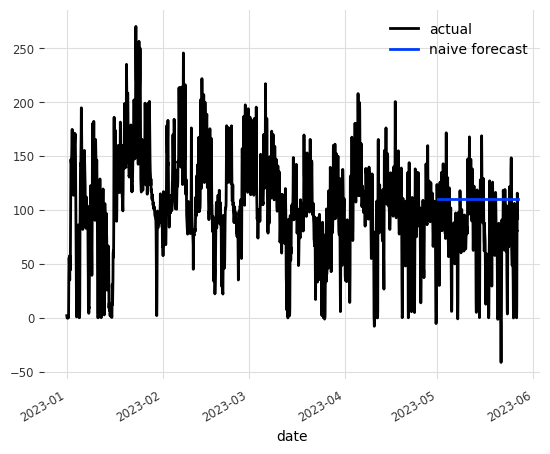

In [3]:
# Fit the NaiveSeasonal model
seasonal_model = NaiveSeasonal()
seasonal_model.fit(train)

# Forecast using the model
seasonal_forecast = seasonal_model.predict(len(test))

# Calculate RMSE
navieseasonal_rmse = rmse(test, seasonal_forecast)
print("Model {} obtains RMSE: {:.2f}".format(seasonal_model, navieseasonal_rmse))

ts.plot(label="actual", alpha=0.05)
seasonal_forecast.plot(label="naive forecast", alpha=0.05)

Root Mean absolute percentage error for the combined naive drift + seasonal: 56.97.


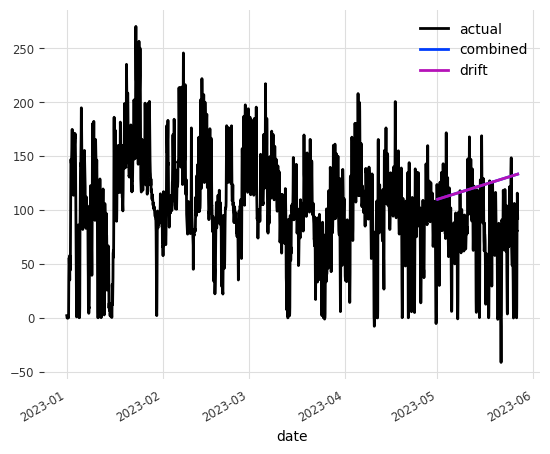

In [4]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(len(test))

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()
combined_forecast_rmse = rmse(ts, combined_forecast)
print(
    "Root Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}.".format(
        combined_forecast_rmse))

ts.plot(label="actual")
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

  0%|          | 0/1380 [00:00<?, ?it/s]

RMSE = 35.74


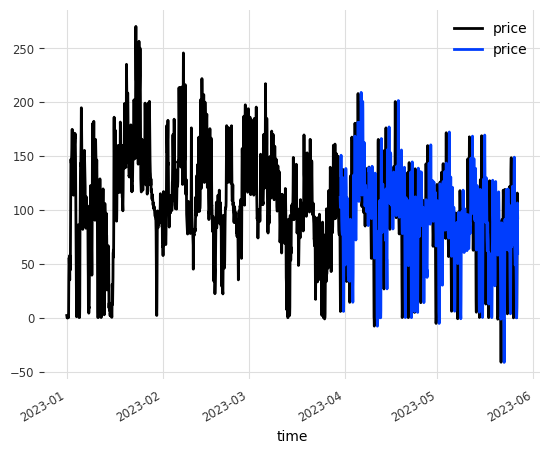

In [5]:
models = [NaiveDrift(), NaiveSeasonal(24)]

ensemble_model = NaiveEnsembleModel(models=models)

# we will see our ensemble model ability
backtest = ensemble_model.historical_forecasts(
    ts, start=0.6, forecast_horizon=24, verbose=True
)
ensemble_rmse = rmse(backtest, ts)
print("RMSE = %.2f" % (ensemble_rmse))
ts.plot()
backtest.plot()